<a href="https://colab.research.google.com/github/evan-person/KerasTutorialMLcourse/blob/feature/AudioKerasTutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Keras Tutorial



References used:

https://github.com/sarthak268/Audio_Classification_using_LSTM/blob/master/DL_Assignment_2.pdf

https://www.kaggle.com/mmoreaux/audio-cats-and-dogs

https://elitedatascience.com/keras-tutorial-deep-learning-in-python


Feature extraction:
librosa documentation



Load libraries

In [0]:
import numpy as np
import pandas as pd
from google.colab import files
from os import walk
import os
from os import listdir
import librosa
import matplotlib.pyplot as plt
import librosa.display
import sklearn
from sklearn.model_selection import KFold
import random

Part 1: Load data

I found a dataset on Kaggle that includes noises of cats and dogs, which is included in my references. I had to delete 4 cat training files to make my zipped files fit on gitHub, but such is life. This dataset is naturally a nice binary classification problem. 


In [2]:
! git clone https://github.com/evan-person/KerasTutorialMLcourse.git



Cloning into 'KerasTutorialMLcourse'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 16 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (16/16), done.


In [10]:

! unzip -q ./KerasTutorialMLcourse/catTrain.zip -d  ./catTrain 
! unzip -q ./KerasTutorialMLcourse/dogTrain.zip -d ./dogTrain 
! unzip -q ./KerasTutorialMLcourse/catTest.zip -d ./catTest 
! unzip -q ./KerasTutorialMLcourse/dogTest.zip -d ./dogTest 
#! ls -R

replace ./catTrain/cat/cat_1.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  ./KerasTutorialMLcourse/dogTrain.zip
replace ./dogTrain/dog/dog_barking_0.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  ./KerasTutorialMLcourse/catTest.zip
replace ./catTest/cat/cat_110.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  ./KerasTutorialMLcourse/dogTest.zip
replace ./dogTest/dog/dog_barking_112.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [8]:
trainFilesD = listdir('./dogTrain/dog')
trainFilesC = listdir('./catTrain/cat')
testFilesD = listdir('./dogTest/dog')
testFilesC = listdir('./catTest/cat')

print('There are',len(trainFilesD),' dog training files')
print('There are', len(trainFilesC),'cat training files')
print('There are',len(testFilesD),' dog test files')
print('There are', len(testFilesC),' cat test files')

#put them all in one folder for test and one folder for train

! mkdir train
! mkdir test
! cp -R ./dogTrain/dog/. ./train
! cp -R ./catTrain/cat/. ./train
! cp -R ./dogTest/dog/. ./test
! cp -R ./catTest/cat/. ./test

There are 85  dog training files
There are 120 cat training files
There are 28  dog test files
There are 39 cat test files


In [0]:
nTrain = len(trainFilesD) + len(trainFilesC)
nTest = len(testFilesD) + len(testFilesC)
trainFiles = os.listdir('./train')
#One example found cropped all sound clips to 4 seconds, but I'm going to ignore that unless I have issues making stuff work
#initially I will start with just a simple audio feature
featureMatrix = np.zeros((nTrain,128,100,1))
cat0dog1 = np.zeros((nTrain))
counter = 0 #this is hacky and I feel gross for doing this
for ii in trainFiles:
  sound, sr = librosa.load(os.path.join('./train/',ii))
  s = librosa.feature.melspectrogram(y=sound,sr=sr,n_fft = 2048, hop_length = 512, n_mels=128,fmax=8000)
  s_db = librosa.power_to_db(s,ref=np.max)
  s_db /= 80
  if s.shape[1] <= 100:
    featureMatrix[counter,0:s.shape[0],0:s.shape[1],0] = s_db
  else:
    featureMatrix[counter,:,:,0] = s_db[:,0:100] #why did I have to change this to 0:100 instead of 0:99
  if ii[0] == 'd':
    cat0dog1[counter] = 1 #i could compress this into one statement without the if, but i'm lazy right now

  counter += 1

In [48]:
sound, sr = librosa.load(os.path.join('./train/',trainFiles[1]))
print(sound.shape)
print(sr)
smat = np.zeros((128,100))
s = librosa.feature.melspectrogram(y=sound,sr=sr,n_fft = 2048, hop_length = 512, n_mels=128,fmax=8000)
print(s.shape)
if s.shape[1] <= 100:
  smat[0:s.shape[0],0:s.shape[1]] = s
else:
  smat = s[:,0:99]
mfccs = librosa.feature.mfcc(y=sound,sr=sr,S=None,n_mfcc=20)

print(mfccs.shape)
print(trainFiles[0])

(181075,)
22050
(128, 354)
(20, 354)
cat_11.wav


In [28]:
print(trainFiles)

['cat_11.wav', 'dog_barking_20.wav', 'cat_72.wav', 'cat_101.wav', 'cat_9.wav', 'cat_22.wav', 'cat_154.wav', 'dog_barking_22.wav', 'cat_34.wav', 'cat_21.wav', 'cat_155.wav', 'cat_164.wav', 'dog_barking_26.wav', 'cat_74.wav', 'cat_96.wav', 'cat_119.wav', 'cat_63.wav', 'cat_114.wav', 'cat_149.wav', 'cat_124.wav', 'cat_4.wav', 'cat_108.wav', 'cat_159.wav', 'cat_87.wav', 'dog_barking_106.wav', 'cat_39.wav', 'cat_23.wav', 'dog_barking_36.wav', 'cat_109.wav', 'cat_102.wav', 'dog_barking_103.wav', 'dog_barking_27.wav', 'cat_142.wav', 'cat_81.wav', 'cat_116.wav', 'dog_barking_65.wav', 'dog_barking_97.wav', 'dog_barking_6.wav', 'cat_35.wav', 'dog_barking_67.wav', 'dog_barking_38.wav', 'cat_32.wav', 'dog_barking_17.wav', 'dog_barking_61.wav', 'cat_146.wav', 'cat_46.wav', 'dog_barking_51.wav', 'dog_barking_55.wav', 'dog_barking_16.wav', 'cat_44.wav', 'dog_barking_108.wav', 'cat_93.wav', 'dog_barking_68.wav', 'cat_127.wav', 'cat_47.wav', 'cat_33.wav', 'cat_106.wav', 'cat_91.wav', 'cat_136.wav', 'ca

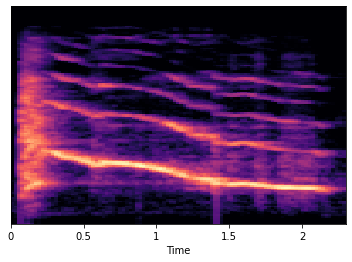

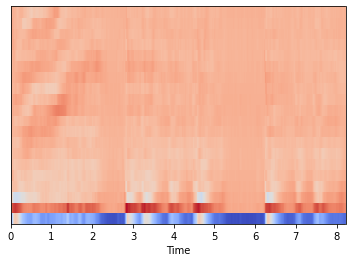

In [47]:
s_db = librosa.power_to_db(smat,ref=np.max)

librosa.display.specshow(s_db,x_axis='time')
plt.show()


librosa.display.specshow(mfccs,x_axis='time')

In [80]:
print(np.max(s_db+80))

80.0


In [73]:
#make some cross validation splits
sampleList = list(range(nTrain))
random.shuffle(sampleList)

indexStep = round(nTrain/5)
print(indexStep)
indexList = np.arange(0,nTrain,indexStep)
print(indexList)

41
[  0  41  82 123 164]


Step 2: 

Creating the Keras model

In [0]:
#call the keras specific stuff here
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from keras.utils.vis_utils import plot_model



In [137]:
#following elite data science tutorial for now

model = Sequential()

model.add(Convolution2D(32,3,3,activation='relu',input_shape=(128,100,1)))

model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(32,activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(1,activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 42, 33, 32)        320       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 21, 16, 32)        0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 10752)             0         
_________________________________________________________________
dense_44 (Dense)             (None, 32)                344096    
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 33        
Total params: 344,449
Trainable params: 344,449
Non-trainable params: 0
_________________________________________________________________
None


In [138]:
model.fit(featureMatrix,cat0dog1,batch_size = 10,nb_epoch = 10, verbose = 1)

21/21 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - accuracy: 0.4146


In [139]:
print(cat0dog1.shape)

(205,)


In [143]:
doubleColumnCatDog = np.array((cat0dog1,1-cat0dog1))
print(doubleColumnCatDog.shape)

(2, 205)


In [147]:
#following elite data science tutorial for now

model = Sequential()

model.add(Convolution2D(32,3,3,activation='relu',input_shape=(128,100,1)))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())


Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 42, 33, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 21, 16, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 21, 16, 32)        0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 10752)             0         
_________________________________________________________________
dense_48 (Dense)             (None, 32)                344096    
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 2)               

In [148]:
model.fit(featureMatrix,doubleColumnCatDog.T,batch_size = 10,nb_epoch = 10, verbose = 1)

21/21 [==============================] - 0s 15ms/step - loss: 0.7396 - accuracy: 0.5561


In [0]:
#score = model.evaluate(testFeature,testLabel,verbose=0)